#### The following notebook was written by AI22BTECH11018 and AI22BTECH11001, using AI22BTECH11023's template for FedAvg to implement the Reptile Algorithm

## Importing Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-11-29 21:57:39.362121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 21:57:40.644362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


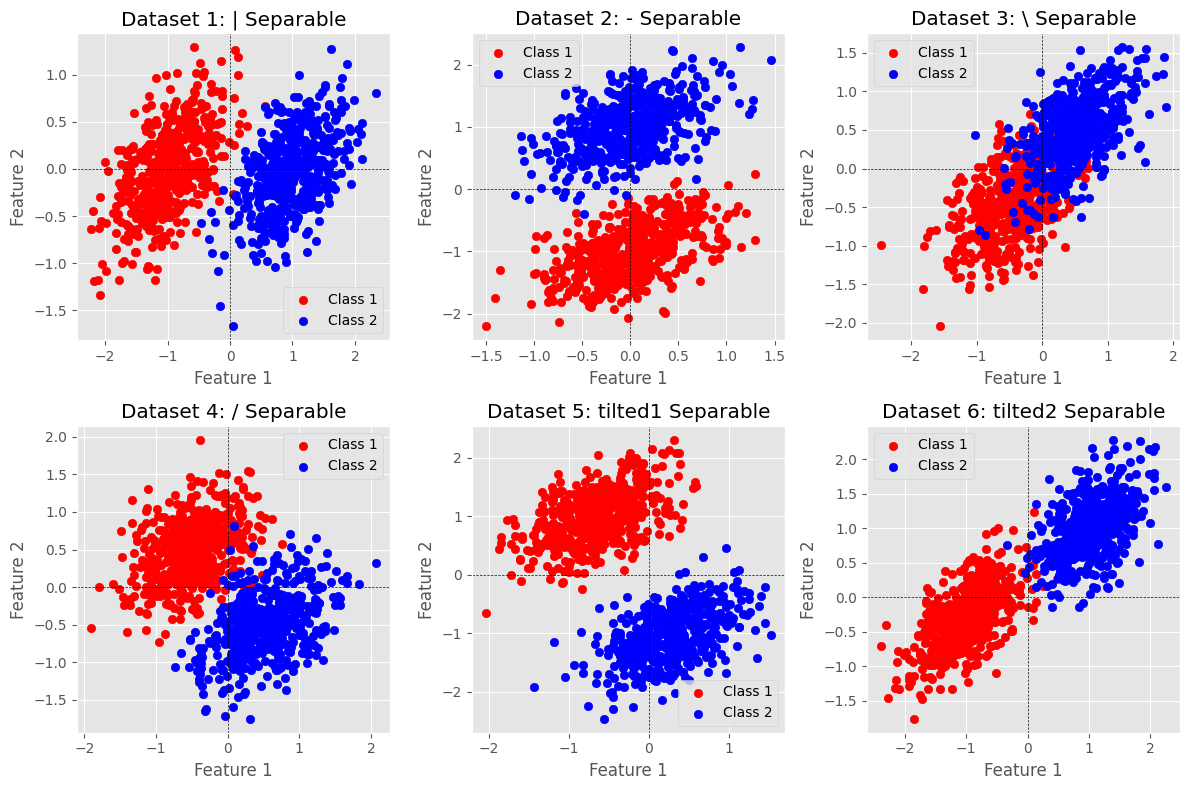

In [2]:
# Synthetic Data Generation

import numpy as np
import matplotlib.pyplot as plt

def generate_bivariate_data(mean1, mean2, cov, n_samples, label1, label2):
    class1 = np.random.multivariate_normal(mean1, cov, n_samples)
    class2 = np.random.multivariate_normal(mean2, cov, n_samples)
    labels1 = np.full((n_samples,), label1)
    labels2 = np.full((n_samples,), label2)
    return class1, labels1, class2, labels2

def plot_data(data1, data2, title):
    plt.scatter(data1[:, 0], data1[:, 1], c='red', label='Class 1')
    plt.scatter(data2[:, 0], data2[:, 1], c='blue', label='Class 2')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.legend()
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)

n_samples = 500
covariance = [[0.2, 0.1], [0.1, 0.2]]
datasets = np.array([
    ([-1, 0], [1, 0], '|'),             # Vertically separable
    ([0, -1], [0, 1], '-'),            # Horizontally separable
    ([-0.5, -0.5], [0.5, 0.5], '\\'),  # Diagonal (\) separable
    ([-0.5, 0.5], [0.5, -0.5], '/'),   # Diagonal (/) separable
    ([-0.7, 1], [0.3, -1], 'tilted1'), # Slightly tilted separable
    ([-1, -0.3], [1, 1], 'tilted2')    # Slightly tilted separable (opposite)
], dtype=object)

num_clients = 6

x_class1 = np.zeros((num_clients, n_samples, 2))
x_class2 = np.zeros((num_clients, n_samples, 2))
y_class1 = np.zeros((num_clients, n_samples))
y_class2 = np.zeros((num_clients, n_samples))

plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

for i in range(datasets.shape[0]):
    mean1, mean2, title = datasets[i]
    x_class1[i], y_class1[i], x_class2[i], y_class2[i] = generate_bivariate_data(mean1, mean2, covariance, n_samples, 0, 1)
    plt.subplot(2, 3, i + 1)
    plot_data(x_class1[i], x_class2[i], f"Dataset {i + 1}: {title} Separable")

print()

plt.tight_layout()
plt.show()

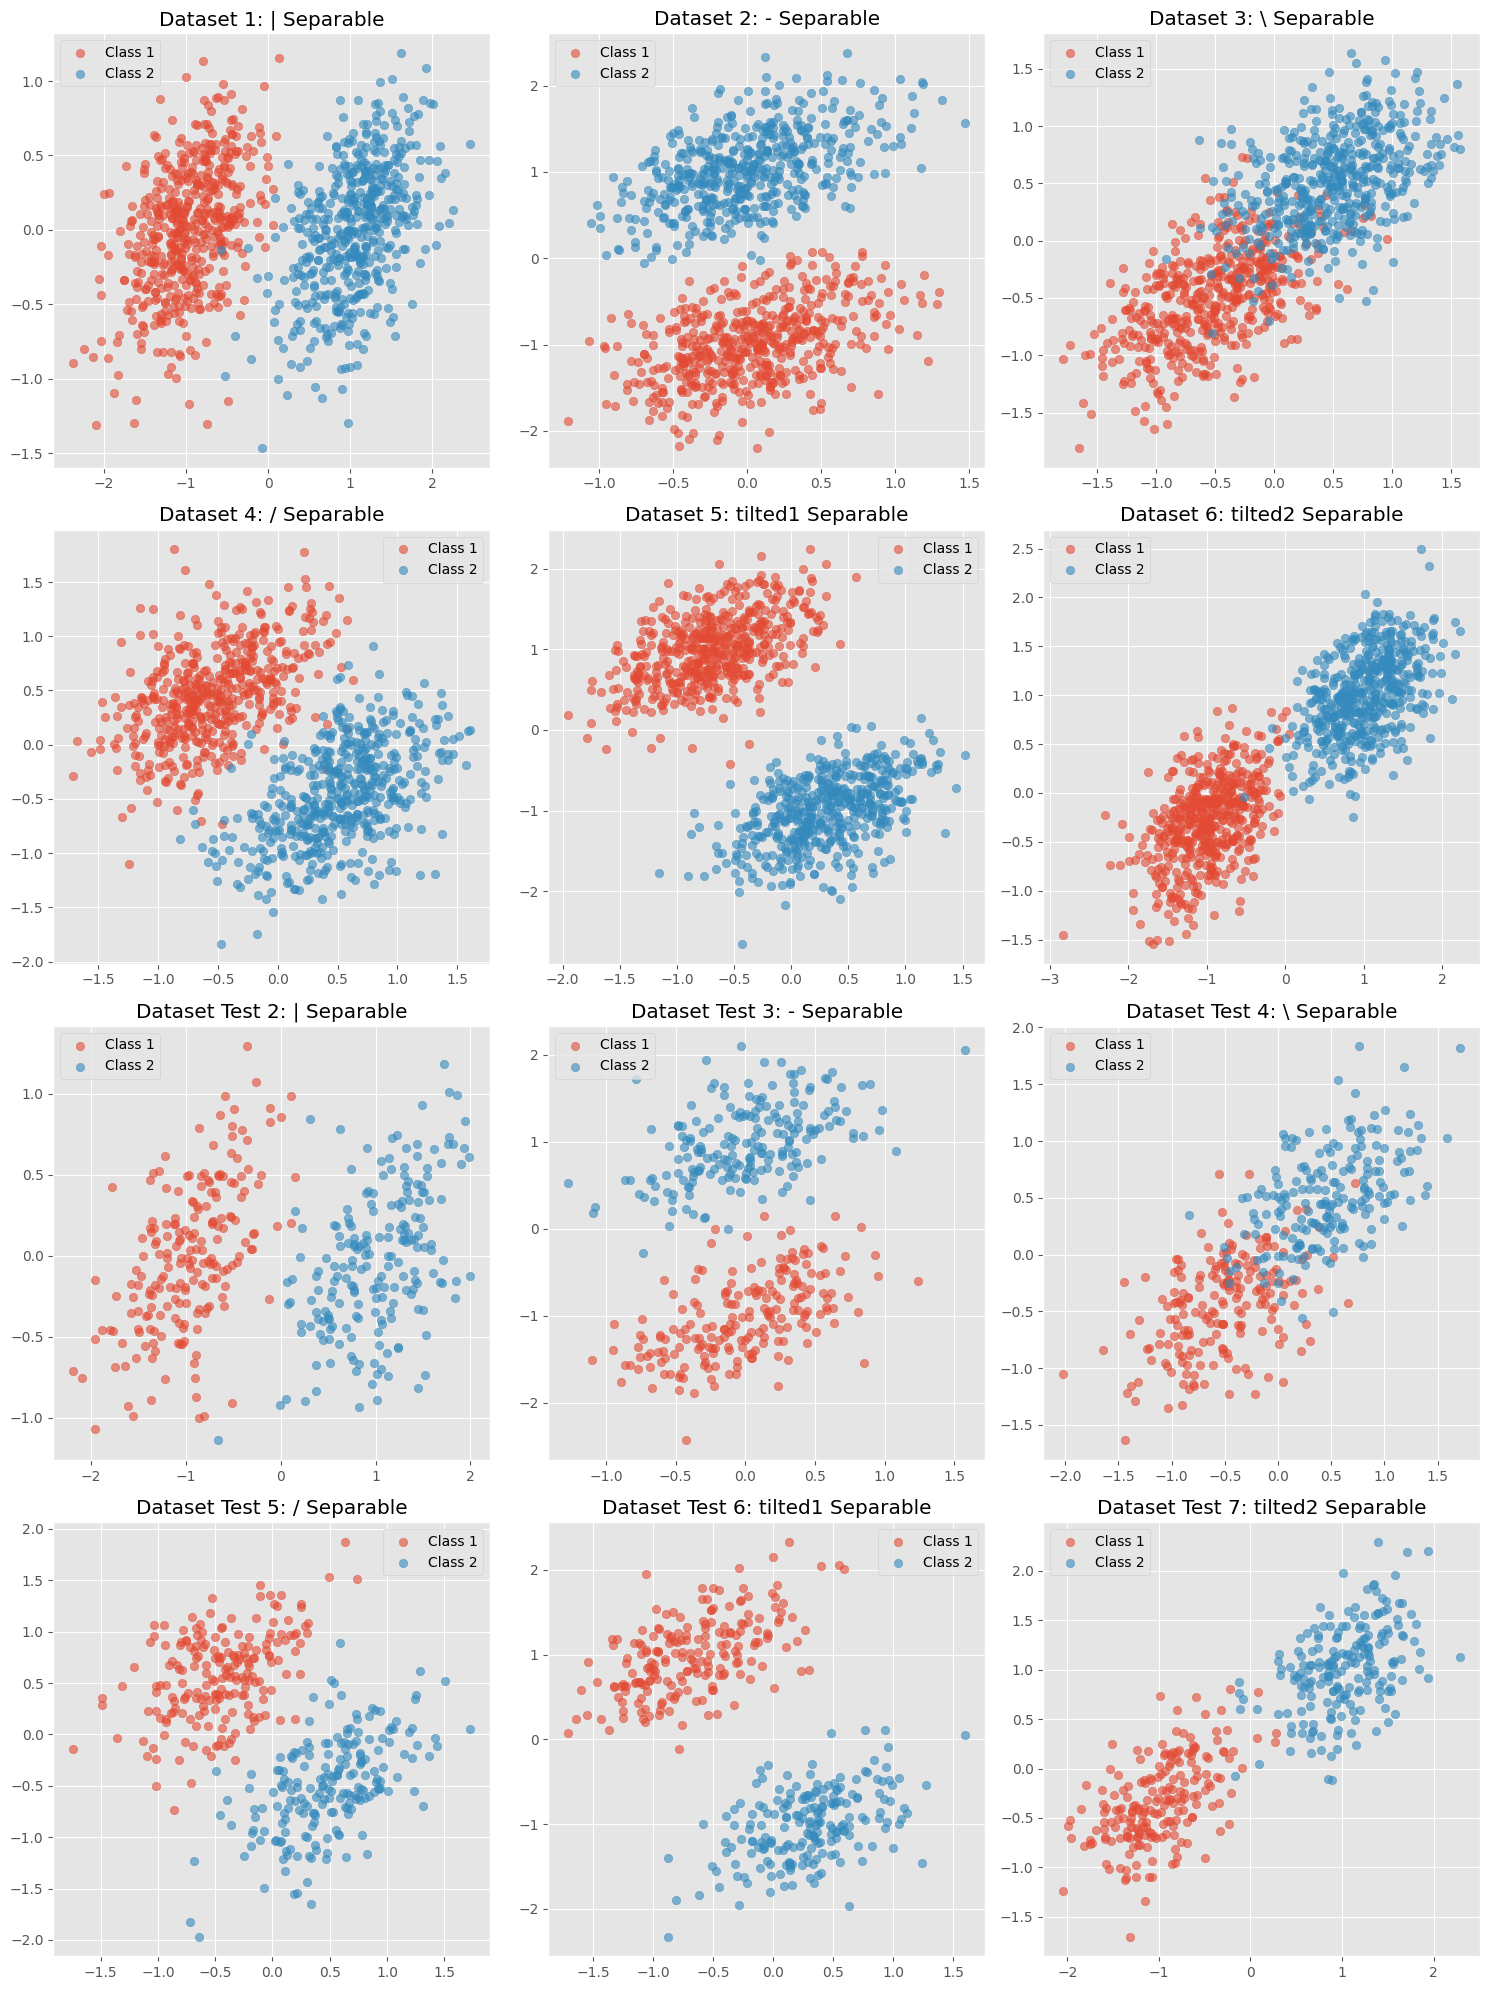

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


def plot_data(x1, x2, title):
    plt.scatter(x1[:, 0], x1[:, 1], label="Class 1", alpha=0.6)
    plt.scatter(x2[:, 0], x2[:, 1], label="Class 2", alpha=0.6)
    plt.title(title)
    plt.legend()

# Generate data for all clients
X_split = []
Y_split = []
X_test = []
y_test = []

n_samples = 500
n_samples_test = 200

x_class1 = np.zeros((num_clients, n_samples, 2))
x_class2 = np.zeros((num_clients, n_samples, 2))
y_class1 = np.zeros((num_clients, n_samples))
y_class2 = np.zeros((num_clients, n_samples))

x_class1_test = np.zeros((num_clients, n_samples_test, 2))
x_class2_test = np.zeros((num_clients, n_samples_test, 2))
y_class1_test = np.zeros((num_clients, n_samples_test))
y_class2_test = np.zeros((num_clients, n_samples_test))

plt.figure(figsize=(15, 20))

for i in range(num_clients):
    mean1, mean2, title = datasets[i]
    x_class1[i], y_class1[i], x_class2[i], y_class2[i] = generate_bivariate_data(mean1, mean2, covariance, n_samples, 0, 1)
    x_class1_test[i], y_class1_test[i], x_class2_test[i], y_class2_test[i] = generate_bivariate_data(mean1, mean2, covariance, n_samples_test, 0, 1)
    
    # Combine class 1 and class 2
    X_client = np.vstack((x_class1[i], x_class2[i]))
    Y_client = np.concatenate((y_class1[i], y_class2[i]))
    X_client_test = np.vstack((x_class1_test[i], x_class2_test[i]))
    Y_client_test = np.concatenate((y_class1_test[i], y_class2_test[i]))

    # Shuffle the data
    perm = np.random.permutation(X_client.shape[0])
    perm2 = np.random.permutation(X_client_test.shape[0])
    X_client = X_client[perm]
    Y_client = Y_client[perm]
    X_client_test = X_client_test[perm2]
    Y_client_test = Y_client_test[perm2]
    
    # Append to client datasets
    X_split.append(X_client)
    # Y_split.append(to_categorical(Y_client))  # One-hot encoding for binary classification
    Y_split.append(Y_client)  # Binary labels for logistic regression
    X_test.append(X_client_test)
    y_test.append(Y_client_test)

    # Plot the data
    plt.subplot(4, 3, i + 1)
    plot_data(x_class1[i], x_class2[i], f"Dataset {i + 1}: {title} Separable")
    plt.subplot(4, 3, i + 7)
    plot_data(x_class1_test[i], x_class2_test[i], f"Dataset Test {i + 2}: {title} Separable")
    

plt.tight_layout()
plt.show()



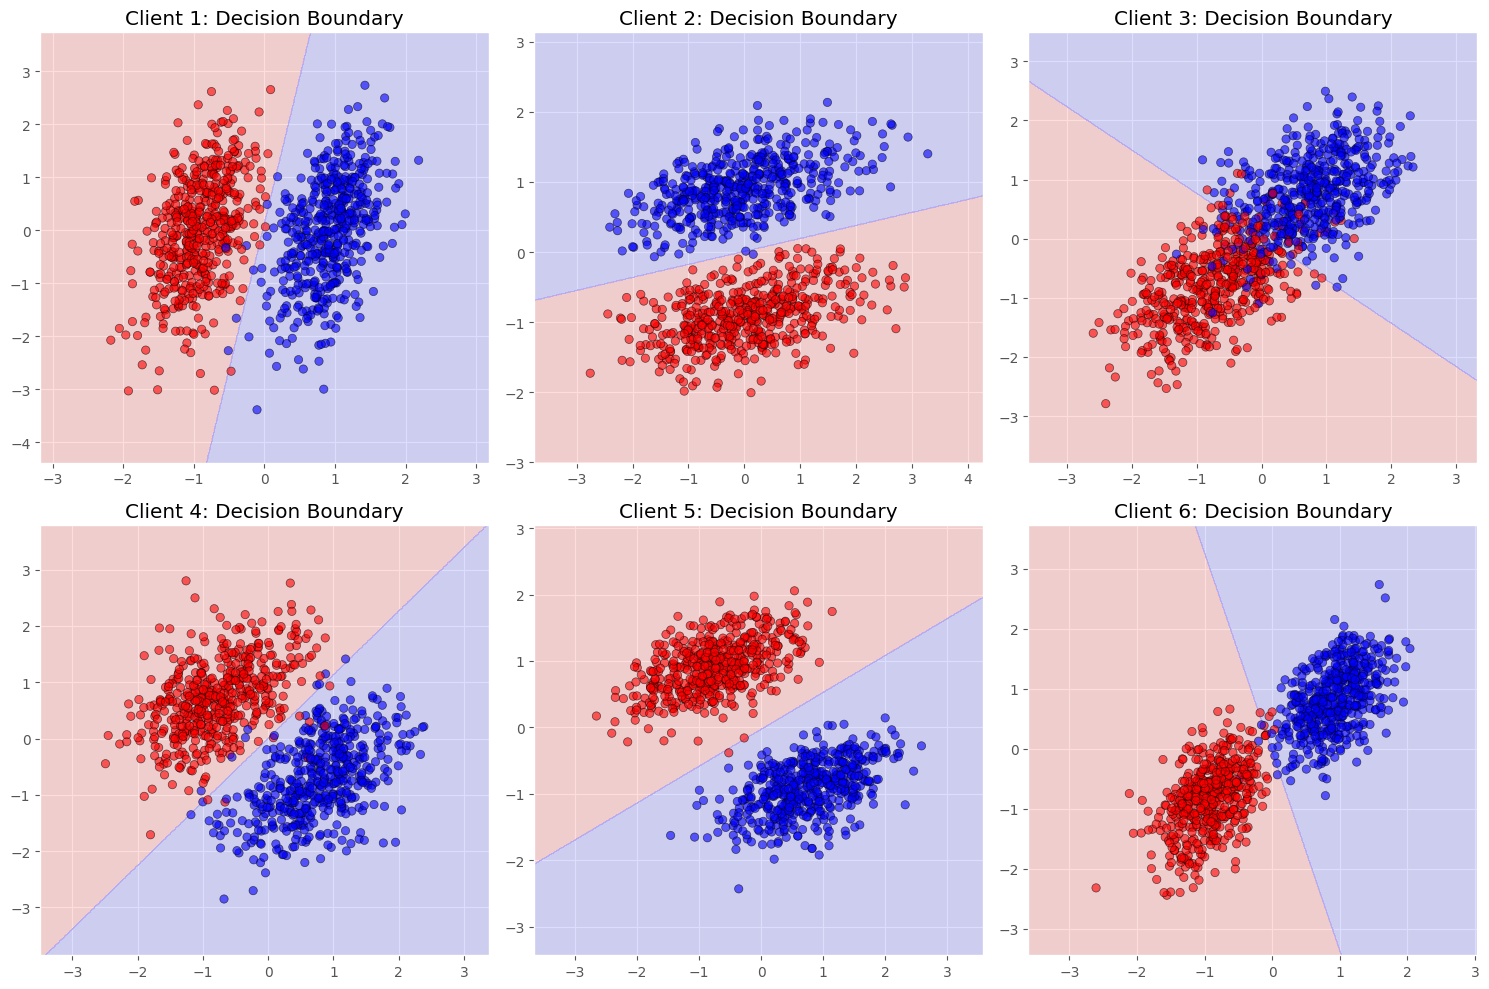

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_background)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap_points, alpha=0.6)
    ax.set_title(title)

# Train logistic regression models and plot decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (X_client, Y_client) in enumerate(zip(X_split, Y_split)):
    # Check if Y_client is one-hot encoded (2D) or already a 1D label array
    if Y_client.ndim == 2:
        # Convert one-hot labels to binary labels
        y_client = np.argmax(Y_client, axis=1)
    else:
        # Already a 1D label array, use it directly
        y_client = Y_client
    
    # Standardize the features
    scaler = StandardScaler()
    X_client_scaled = scaler.fit_transform(X_client)
    
    # Train logistic regression
    model = LogisticRegression()
    model.fit(X_client_scaled, y_client)
    
    # Plot decision boundary
    plot_decision_boundary(
        model,
        X_client_scaled,
        y_client,
        ax=axes[i],
        title=f"Client {i + 1}: Decision Boundary"
    )

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_background)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap_points)
    ax.set_title(title)

# Train logistic regression models and plot decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (X_client, Y_client) in enumerate(zip(X_split, Y_split)):
    # Convert one-hot labels to binary
    y_client = np.argmax(Y_client, axis=1)
    
    # Standardize the features
    scaler = StandardScaler()
    X_client_scaled = scaler.fit_transform(X_client)
    
    # Train logistic regression
    model = LogisticRegression()
    model.fit(X_client_scaled, y_client)
    
    # Plot decision boundary
    plot_decision_boundary(
        model,
        X_client_scaled,
        y_client,
        ax=axes[i],
        title=f"Client {i + 1}: Decision Boundary"
    )

plt.tight_layout()
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten


input_dim = 2
def build_model():
    # Define a logistic regression model
    model = Sequential([
        Flatten(input_shape=(input_dim,)),  # Flatten layer to handle input shape
        Dense(1, activation='sigmoid')     # Logistic regression: single dense neuron with sigmoid activation
    ])
    return model


--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 0
--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------
CLIENT ID: 3
--------------------------------------------------------------------------------------------------------------------------------
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9801 - loss: 0.3205 - val_accuracy: 0.9725 - val_loss: 0.3159
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.3178 - val_accuracy: 0.9750 - val_loss: 0.3083
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.2987 - val_accuracy: 0.9775 - val_loss: 0.3012
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 

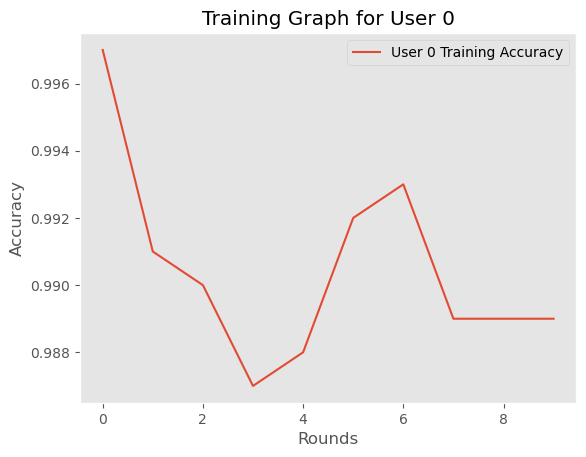

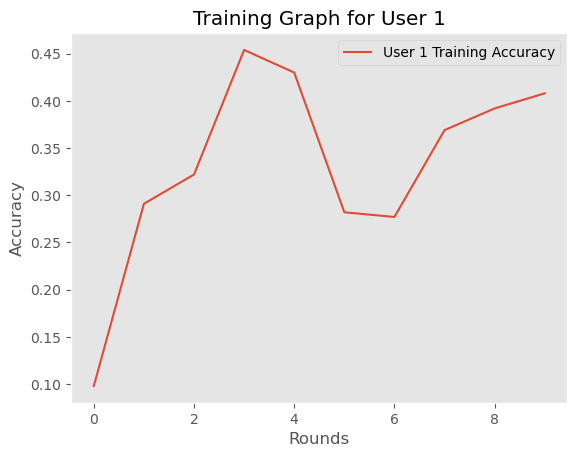

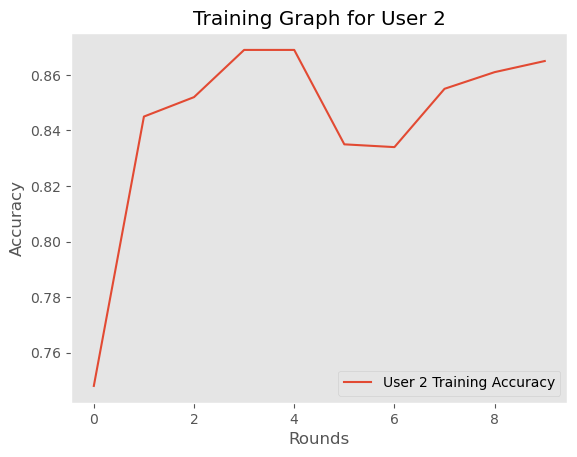

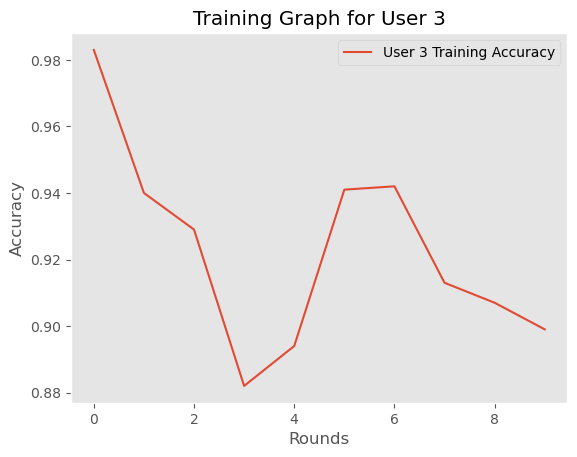

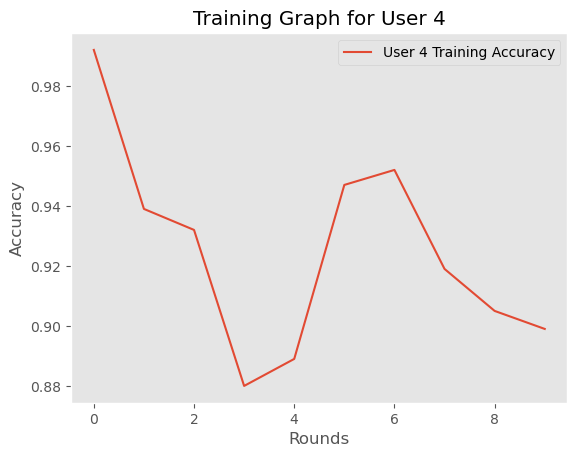

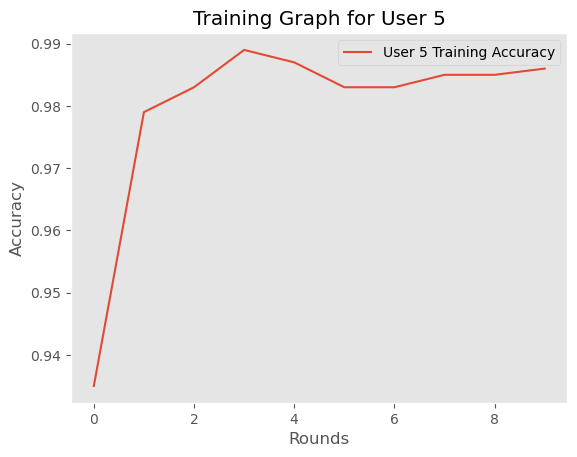

In [10]:
#Federated Learning on ResNet
global_model = build_model()
global_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
w = global_model.get_weights()

model_list = []
n_users = 6
for user in range(n_users):
    m = build_model()
    m.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

num_samples = 3
tr_acc = []
val_acc = []
counts = np.zeros(n_users)

tr_acc = {user: [] for user in range(n_users)}


for epoch in range(10):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("ROUND NUMBER:", epoch)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    w_old = global_model.get_weights()
    w_new = []
    sample_user_list = np.random.choice(n_users, num_samples, replace = False)
    for i in w_old:
        w_new.append(np.zeros(i.shape))
    N = 0
    for user in sample_user_list:
        N += X_split[user].shape[0]
    for user in sample_user_list:
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print("CLIENT ID:", user)
        print("--------------------------------------------------------------------------------------------------------------------------------")
        model_list[user].set_weights(w_old)
        counts[user]+=1
        batch_size = 32
        epochs = 10
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test[user], y_test[user])
        )
        print(history)
        with tf.device('/GPU:0'):
            w_k = model_list[user].get_weights()
        m = X_split[user].shape[0]
        for i in range(len(w_old)):
            w_new[i] += m / N * (w_k[i])
    with tf.device('/GPU:0'):
        global_model.set_weights(w_new)
    
    for user in range(n_users):
        acc = global_model.evaluate(X_split[user], Y_split[user], batch_size=128, verbose=0)[1]
        tr_acc[user].append(acc)

print("Number of times each client was chosen")
print(counts)

for user in range(n_users):
    plt.figure()
    plt.plot(range(10), tr_acc[user], label=f'User {user} Training Accuracy')
    plt.grid()
    plt.legend()
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title(f'Training Graph for User {user}')
    plt.show()

# Saving the model obtained after the fedavg steps

global_model_fed_avg = build_model()
global_model_fed_avg.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
global_model_fed_avg.set_weights(global_model.get_weights())

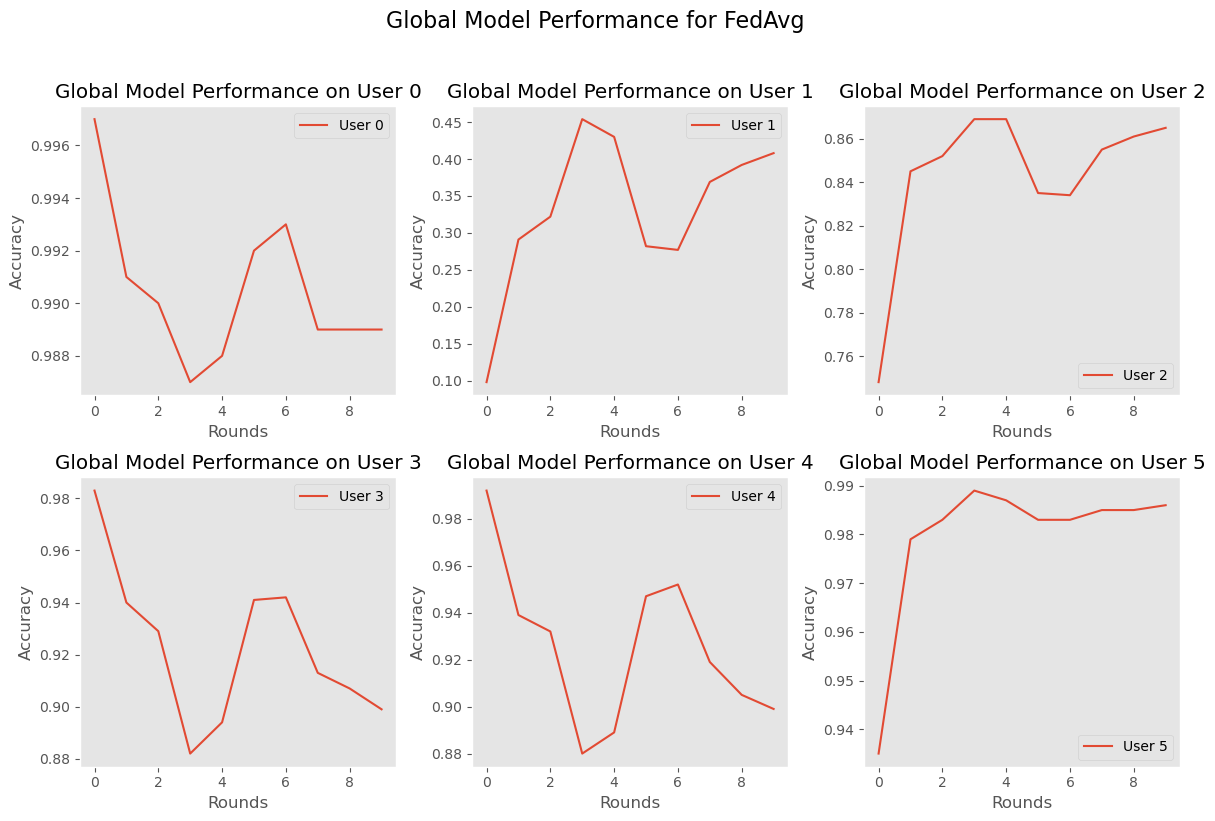

In [11]:
import matplotlib.pyplot as plt

# Number of rows and columns for the subplots
rows = (n_users + 2) // 3  # Adjust rows to fit users (3 users per row as default)
cols = 3  # 3 subplots per row

# Create a smaller figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Smaller size: width=12, height scales with rows
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot the training accuracy for each user
for user in range(n_users):
    ax = axes[user]
    ax.plot(range(10), tr_acc[user], label=f'User {user}')
    ax.grid()
    ax.legend()
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Global Model Performance on User {user}')

# Remove any unused subplots if n_users is not a perfect multiple of cols
for i in range(n_users, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Global Model Performance for FedAvg', fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to make space for the global title
plt.show()

In [155]:
results = global_model.evaluate(X_test, y_test, batch_size=128)
results = global_model.evaluate(X_train, y_train, batch_size=128)

14/14 [==============================] - 0s 22ms/step - loss: 0.0319 - accuracy: 0.8244


In [12]:
# Batch Reptile algorithm

'''
Pseudo code:

Sample client, find the new weights, by training with the local data

Update the global gradient, using a first order approximation. This is similar to the TD algorithm in RL
'''

global_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model_list = []
for user in range(n_users):
    m = build_model()
    m.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_list.append(m)

num_iterations = 10

K = 5  # Number of local epochs

epsilon = 0.1

tr_acc = {user: [] for user in range(n_users)}


for iteration in range(num_iterations):
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("ROUND NUMBER:", epoch)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    w_old = global_model.get_weights()
    delta = []
    sample_user_list = np.random.choice(n_users, num_samples, replace = False)
    for i in w_old:
        delta.append(np.zeros(i.shape))
    N = 0
    for user in sample_user_list:
        N += X_split[user].shape[0]
    for user in sample_user_list:
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print("CLIENT ID:", user)
        print("--------------------------------------------------------------------------------------------------------------------------------")
        model_list[user].set_weights(w_old)
        counts[user]+=1
        batch_size = 32
        epochs = K
        history = model_list[user].fit(
            X_split[user], Y_split[user],
            batch_size=batch_size,
            epochs=K,
            validation_data=(X_test[user], y_test[user])
        )
        print(history)
        with tf.device('/GPU:0'):
            w_k = model_list[user].get_weights()
        m = X_split[user].shape[0]
        for i in range(len(w_old)):
            delta[i] = delta[i] + (w_k[i] - w_old[i])
            
    with tf.device('/GPU:0'):
        w_new = [w_old[i] + epsilon * delta[i] / num_samples for i in range(len(w_old))]
        global_model.set_weights(w_new)
    for user in range(n_users):
        acc = global_model.evaluate(X_split[user], Y_split[user], batch_size=128, verbose=0)[1]
        tr_acc[user].append(acc)
    
    
# Saving the model obtained after the fedavg steps

global_model_reptile = build_model()
global_model_reptile.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
global_model_reptile.set_weights(global_model.get_weights())        


--------------------------------------------------------------------------------------------------------------------------------
ROUND NUMBER: 9
--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------
CLIENT ID: 3
--------------------------------------------------------------------------------------------------------------------------------
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9148 - loss: 0.3030 - val_accuracy: 0.9025 - val_loss: 0.3273
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9021 - loss: 0.3182 - val_accuracy: 0.9100 - val_loss: 0.3212
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9114 - loss: 0.2962 - val_accuracy: 0.9100 - val_loss: 0.3152
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.29

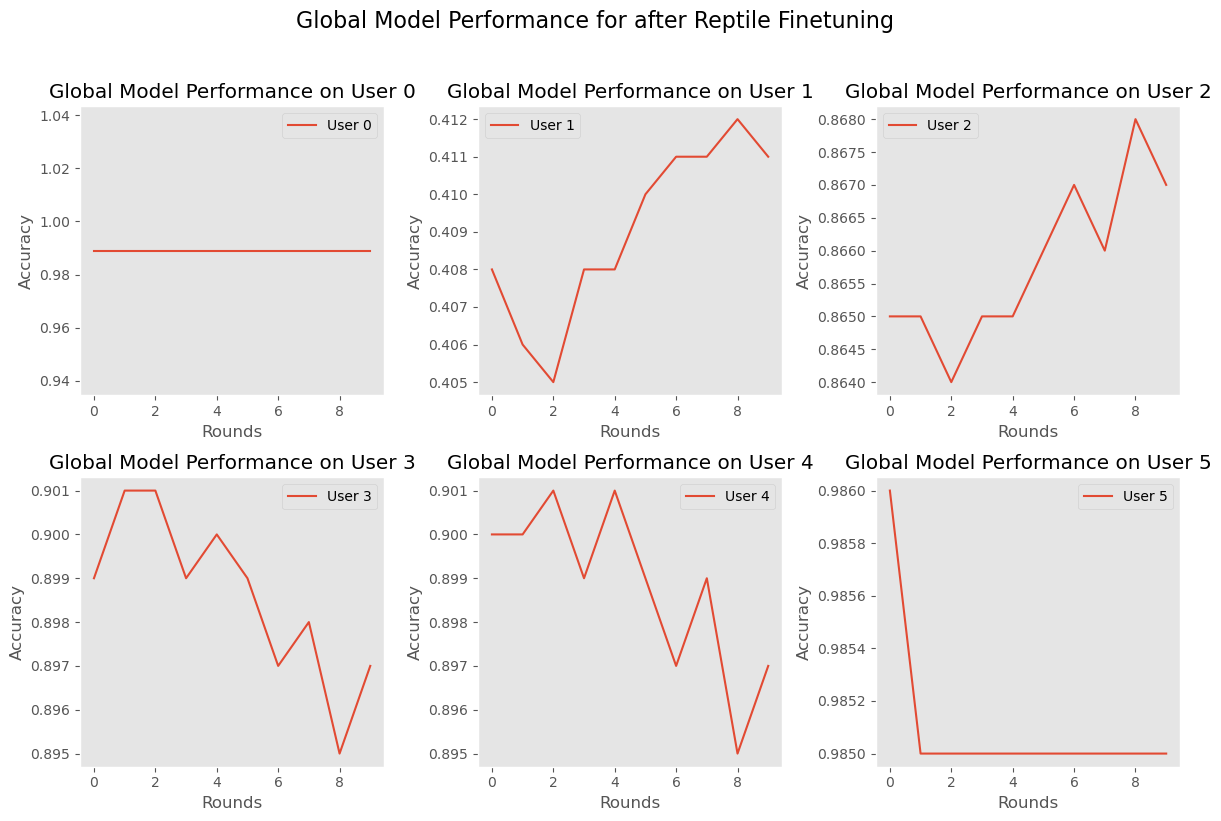

In [13]:
import matplotlib.pyplot as plt

# Number of rows and columns for the subplots
rows = (n_users + 2) // 3  # Adjust rows to fit users (3 users per row as default)
cols = 3  # 3 subplots per row

# Create a smaller figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Smaller size: width=12, height scales with rows
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot the training accuracy for each user
for user in range(n_users):
    ax = axes[user]
    ax.plot(range(10), tr_acc[user], label=f'User {user}')
    ax.grid()
    ax.legend()
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Global Model Performance on User {user}')

# Remove any unused subplots if n_users is not a perfect multiple of cols
for i in range(n_users, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Global Model Performance for after Reptile Finetuning', fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to make space for the global title
plt.show()

Training personalized models for Client 0...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_252. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_255. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_258. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


Training personalized models for Client 1...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_261. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_264. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_267. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


Training personalized models for Client 2...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_270. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_273. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_276. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


Training personalized models for Client 3...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_279. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_282. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_285. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


Training personalized models for Client 4...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_288. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_291. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_294. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


Training personalized models for Client 5...


/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_297. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_300. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(
/home/aviator98/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_303. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(



--- Performance Metrics ---
m_per_fed_avg: Average Loss = 0.3001, Average Accuracy = 0.8738
m_per_reptile: Average Loss = 0.2985, Average Accuracy = 0.8723
m_ran: Average Loss = 0.5927, Average Accuracy = 0.6665
global_model_fed_avg: Average Loss = 0.3698, Average Accuracy = 0.8410
global_model_reptile: Average Loss = 0.3667, Average Accuracy = 0.8410


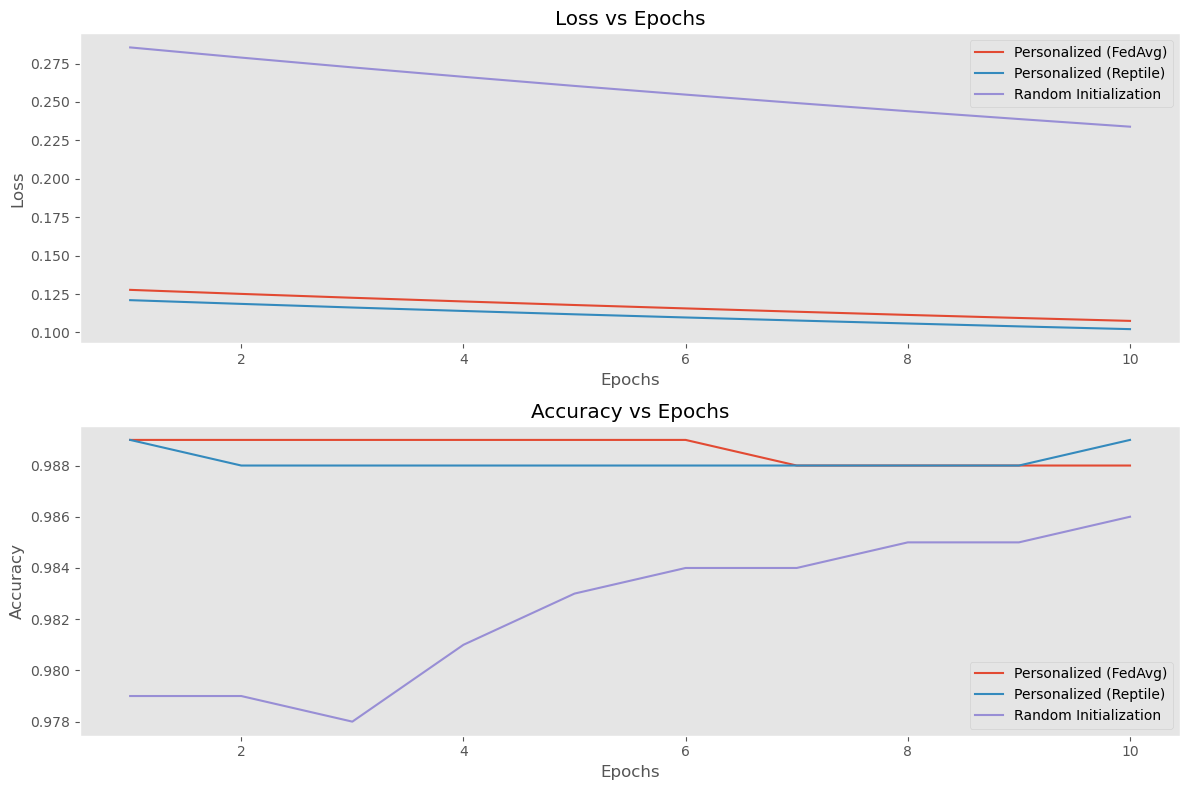

In [18]:
import matplotlib.pyplot as plt

# Dictionary to store performance metrics for each model
performance_metrics = {
    "m_per_fed_avg": {"loss": [], "accuracy": []},
    "m_per_reptile": {"loss": [], "accuracy": []},
    "m_ran": {"loss": [], "accuracy": []},
    "global_model_fed_avg": {"loss": [], "accuracy": []},
    "global_model_reptile": {"loss": [], "accuracy": []},
}

# List to store histories for personalized models
history_per_fed_avg = []
history_per_reptile = []
history_ran = []

num_epochs = 30

for user in range(n_users):
    print(f"Training personalized models for Client {user}...")

    # Personalized training after only FedAvg
    m_per_fed_avg = build_model()
    m_per_fed_avg.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    m_per_fed_avg.set_weights(global_model_fed_avg.get_weights())

    history_fed_avg = m_per_fed_avg.fit(
        X_split[user], Y_split[user],
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=0  # Suppress output for clarity
    )
    history_per_fed_avg.append(history_fed_avg)

    # Personalized training after FedAvg and Reptile
    m_per_reptile = build_model()
    m_per_reptile.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    m_per_reptile.set_weights(global_model_reptile.get_weights())

    history_reptile = m_per_reptile.fit(
        X_split[user], Y_split[user],
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=0
    )
    history_per_reptile.append(history_reptile)

    # Random initialized training
    m_ran = build_model()
    m_ran.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    history_random = m_ran.fit(
        X_split[user], Y_split[user],
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=0
    )
    history_ran.append(history_random)

    # Evaluate global and personalized models
    fed_avg_metrics = global_model_fed_avg.evaluate(X_split[user], Y_split[user], verbose=0)
    reptile_metrics = global_model_reptile.evaluate(X_split[user], Y_split[user], verbose=0)

    per_fed_avg_metrics = m_per_fed_avg.evaluate(X_split[user], Y_split[user], verbose=0)
    per_reptile_metrics = m_per_reptile.evaluate(X_split[user], Y_split[user], verbose=0)
    ran_metrics = m_ran.evaluate(X_split[user], Y_split[user], verbose=0)

    # Store metrics
    performance_metrics["global_model_fed_avg"]["loss"].append(fed_avg_metrics[0])
    performance_metrics["global_model_fed_avg"]["accuracy"].append(fed_avg_metrics[1])
    performance_metrics["global_model_reptile"]["loss"].append(reptile_metrics[0])
    performance_metrics["global_model_reptile"]["accuracy"].append(reptile_metrics[1])
    performance_metrics["m_per_fed_avg"]["loss"].append(per_fed_avg_metrics[0])
    performance_metrics["m_per_fed_avg"]["accuracy"].append(per_fed_avg_metrics[1])
    performance_metrics["m_per_reptile"]["loss"].append(per_reptile_metrics[0])
    performance_metrics["m_per_reptile"]["accuracy"].append(per_reptile_metrics[1])
    performance_metrics["m_ran"]["loss"].append(ran_metrics[0])
    performance_metrics["m_ran"]["accuracy"].append(ran_metrics[1])

# Display average metrics across all users
print("\n--- Performance Metrics ---")
for model_name, metrics in performance_metrics.items():
    avg_loss = sum(metrics["loss"]) / n_users
    avg_accuracy = sum(metrics["accuracy"]) / n_users
    print(f"{model_name}: Average Loss = {avg_loss:.4f}, Average Accuracy = {avg_accuracy:.4f}")

# Generate convergence rate graphs for personalized models
epochs = range(1, 11)

plt.figure(figsize=(12, 8))

# Loss vs Epochs
plt.subplot(2, 1, 1)
plt.plot(epochs, history_per_fed_avg[0].history['loss'], label="Personalized (FedAvg)")
plt.plot(epochs, history_per_reptile[0].history['loss'], label="Personalized (Reptile)")
plt.plot(epochs, history_ran[0].history['loss'], label="Random Initialization")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy vs Epochs
plt.subplot(2, 1, 2)
plt.plot(epochs, history_per_fed_avg[0].history['accuracy'], label="Personalized (FedAvg)")
plt.plot(epochs, history_per_reptile[0].history['accuracy'], label="Personalized (Reptile)")
plt.plot(epochs, history_ran[0].history['accuracy'], label="Random Initialization")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


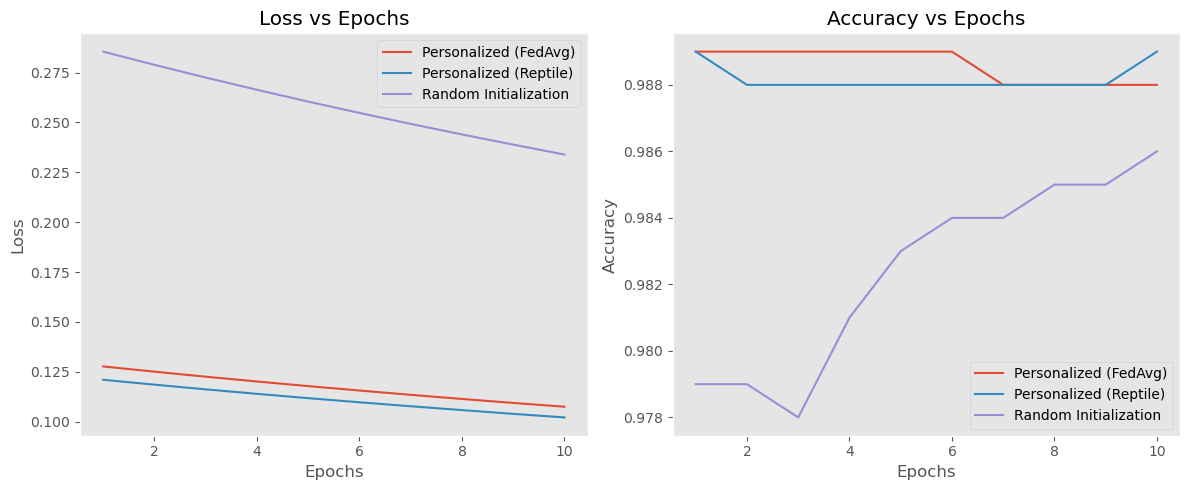

In [25]:

plt.figure(figsize=(12, 5))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, history_per_fed_avg[0].history['loss'], label="Personalized (FedAvg)")
plt.plot(epochs, history_per_reptile[0].history['loss'], label="Personalized (Reptile)")
plt.plot(epochs, history_ran[0].history['loss'], label="Random Initialization")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, history_per_fed_avg[0].history['accuracy'], label="Personalized (FedAvg)")
plt.plot(epochs, history_per_reptile[0].history['accuracy'], label="Personalized (Reptile)")
plt.plot(epochs, history_ran[0].history['accuracy'], label="Random Initialization")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
